# Volatility Modelling


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta
from scipy import signal


#### Data Preparation for Volatility Modelling

In [2]:
max_daily_dataset = nc.Dataset('../../datasets/tasmax_hadukgrid_uk_region_day_19600101-20211231.nc')
min_daily_dataset = nc.Dataset('../../datasets/tasmin_hadukgrid_uk_region_day_19600101-20211231.nc')
region = 10

def convert_hours_to_datetime(hours):
    base_date = datetime(1800, 1, 1, 0, 0, 0)  # Base date for the calculation
    delta = timedelta(hours=hours)  # Create a timedelta based on the hours
    # Add the timedelta to the base date to get the resulting datetime
    result_datetime = base_date + delta
    return result_datetime.date()

region_daily_min = min_daily_dataset['tasmin'][:, region]
region_daily_max = max_daily_dataset['tasmax'][:, region]
data_dict = {'min': region_daily_min, 'max': region_daily_max, 'time': min_daily_dataset['time'][:]}
df = pd.DataFrame(data=data_dict)
df['date'] = df['time'].apply(convert_hours_to_datetime)
df['avg'] = (df['min'] + df['max'])/2
pass



## Daily and monthly Volatility Modelling

First, we look at the monthly rolling volatility in our time series data

/tmp/ipykernel_23674/166740494.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


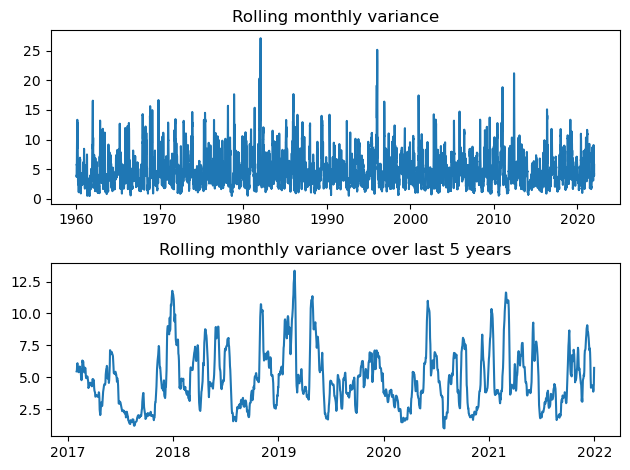

In [10]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['date'], df['avg'].rolling(window = 30).var())
axs[0].set_title("Rolling monthly variance")
axs[1].plot(df['date'][-365*5:], df['avg'][-365*5:].rolling(window = 30).var())
axs[1].set_title("Rolling monthly variance over last 5 years")
fig.tight_layout()
fig.show()

In [31]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract day and month from the 'date' column
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

# Group by day and month, and compute variance for each day
std_by_day = df.groupby(['month', 'day'])['avg'].std()
print(std_by_day)

month  day
1      1      2.927041
       2      2.881849
       3      2.593544
       4      2.552560
       5      2.788373
                ...   
12     27     3.399486
       28     3.652368
       29     3.669040
       30     3.366287
       31     3.165318
Name: avg, Length: 366, dtype: float64


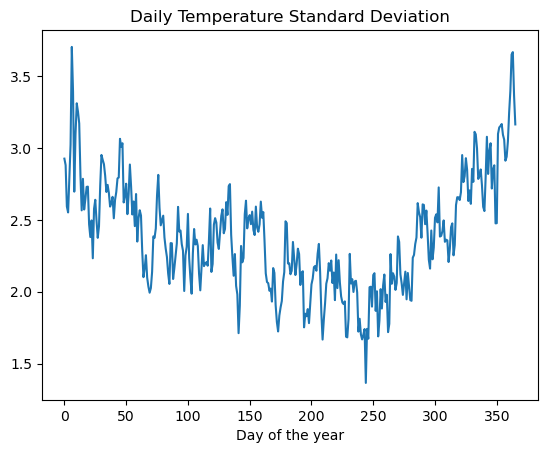

In [32]:
plt.plot(std_by_day.values)
plt.title("Daily Temperature Standard Deviation")
plt.xlabel("Day of the year")
plt.show()

## Piecewise Modelling

Our first simple model will be fitting a piecewise constant function to each month of the year.

Month 1 average standard deviation: 2.7763002417809917
Month 2 average standard deviation: 2.713507633203285
Month 3 average standard deviation: 2.3146612343794626
Month 4 average standard deviation: 2.2733487675745825
Month 5 average standard deviation: 2.375743823973072
Month 6 average standard deviation: 2.211228659500156
Month 7 average standard deviation: 2.0624116896451805
Month 8 average standard deviation: 1.973711600351153
Month 9 average standard deviation: 1.9786444518128625
Month 10 average standard deviation: 2.3254938100930382
Month 11 average standard deviation: 2.6240833015672775
Month 12 average standard deviation: 2.986426498518974


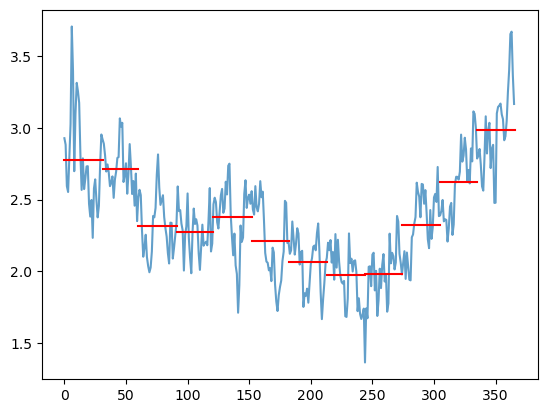

In [33]:
monthly_means = np.zeros(12, dtype=np.float64)
fig, axs = plt.subplots(1)
axs.plot(std_by_day.values, alpha=0.7)
day = 0

for i in range(12):
    month = i + 1
    monthly_means[i] = np.mean(std_by_day[month].values)
    print(f"Month {month} average standard deviation: {monthly_means[i]}")
    newday = day + len(std_by_day[month].values)
    axs.plot([day, newday], [monthly_means[i], monthly_means[i]], color='r')
    day = newday    

## Parameteric Regression

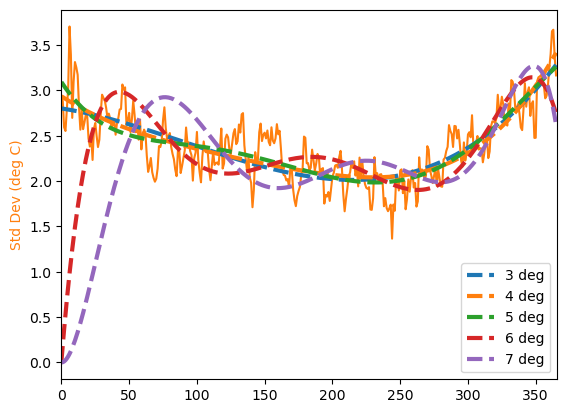

In [39]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Preprocess x, y combinations to handle dimensionality of Polynomial Features
x = np.array(np.arange(len(std_by_day.values.flatten())))
y = np.array(std_by_day.values.flatten())

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

# initialise degrees of freedom
poly_feats3 = PolynomialFeatures(degree=3)
poly_feats4 = PolynomialFeatures(degree=4)
poly_feats5 = PolynomialFeatures(degree=5)
poly_feats6 = PolynomialFeatures(degree=6)
poly_feats7 = PolynomialFeatures(degree=7)

# Fit transform to number of polynomial features
xp3 = poly_feats3.fit_transform(x)
xp4 = poly_feats4.fit_transform(x)
xp5 = poly_feats5.fit_transform(x)
xp6 = poly_feats6.fit_transform(x)
xp7 = poly_feats7.fit_transform(x)

# Fit using ordinary least squares
p3 = sm.OLS(y, xp3).fit()
p4 = sm.OLS(y, xp4).fit()
p5 = sm.OLS(y, xp5).fit()
p6 = sm.OLS(y, xp6).fit()
p7 = sm.OLS(y, xp7).fit()

# Predict using original data and model fit
poly3 = p3.predict(xp3)
poly4 = p4.predict(xp4)
poly5 = p5.predict(xp5)
poly6 = p6.predict(xp6)
poly7 = p7.predict(xp7)

plt.plot(std_by_day.values, color='tab:orange')
plt.plot(poly3, '--', linewidth=3, label='3 deg')
plt.plot(poly4, '--', linewidth=3, label='4 deg')
plt.plot(poly5, '--', linewidth=3, label='5 deg')
plt.plot(poly6, '--', linewidth=3, label='6 deg')
plt.plot(poly7, '--', linewidth=3, label='7 deg')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.xlim(0,366) 
plt.legend(loc='lower right')
plt.show()


## Fourier Series Volatility Modelling



We use the numpy fast fourier series function to calculate the fourier coefficients of the series. These are given analytically by, 

$$ c_{k} = \int_{0}^{1} f(x)e^{-2\pi i k x} dx$$

The inverse fourier transform is then used to reconstruct the signal using these terms, the formula for the reconstructed sequence is given by:

$$ f(x) = \sum_{k=-N}^{N} c_{k} e^{2\pi i k x} $$

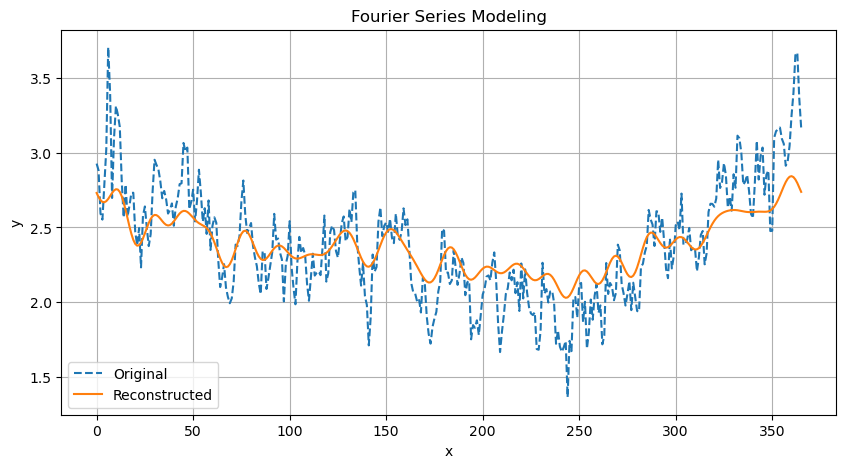

In [65]:
# Preprocess x, y combinations to handle dimensionality of Polynomial Features
x = np.arange(0, 366)
y = np.array(std_by_day.values.flatten())

 # Number of terms in the Fourier series
n_terms = 25
coeffs = np.fft.fft(y)[:n_terms] / len(y)

def fourier_series(x, coeffs):
    n = len(coeffs)
    y_reconstructed = np.zeros_like(x, dtype=complex)
    for k in range(n):
        y_reconstructed += coeffs[k] * np.exp(2j * np.pi * k * x / 365.25)
    return y_reconstructed.real

y_reconstructed = fourier_series(x, coeffs)
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Original', linestyle='dashed')
plt.plot(x, y_reconstructed, label='Reconstructed')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fourier Series Modeling')
plt.grid(True)
plt.show()



## Splines


## Comparing each of these models using AIC and BIC

## Now we aim to model the volatility of the volatility

First we check if the distribution of residuals this is Gaussian, if so we can use a constant

## Kolmogorov-Smirnov and Anderson-Darling Tests

Gives use our final SDE for modelling volatility

## Final SDE model for temperature:

## Monte-Carlo Simulations

